# Reproduce Figure 2 of the 2016 JAMES Tracmip introduction paper

We use approach 1 to access the Pangeo data in the Google Cloud. See load_data_from_pangeo.iypnb in the same folder.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

Wrapper function to load data. Output is a dictionary of xarray data arrays

In [2]:
def load_data(freq, var, exp):
    df = pd.read_csv('https://storage.googleapis.com/cmip6/tracmip.csv')
    # a somewhat cumbersome way to query the dataframe ... 
    df_var = df.query("frequency == \'"+freq+"\'").query("variable == \'"+var+"\'").query("experiment == \'"+exp+"\'")
    gcs = gcsfs.GCSFileSystem(token='anon')
    datadict = dict()
    for zstore in df_var.source.values:
        mapper = gcs.get_mapper(zstore)
        ds = xr.open_zarr(mapper, consolidated=True)
        # write only variable of interest to dictionary, so this becomes a data array
        datadict[ds.attrs['model_id']] = ds[var] 
    return datadict

Load clear-sky radiative fluxes at the surface, based on which we then calculate surface albedo, as well as surface temperature.

In [3]:
rsdscs = load_data('Amon', 'rsdscs', 'aquaControl')
rsuscs = load_data('Amon', 'rsuscs', 'aquaControl')
ts     = load_data('Amon', 'ts'    , 'aquaControl')

Restrict data to last 20 years and average over these as well as over the spatial domain. Note that this will overwrite the dictionaries.

In [4]:
def timemean_globalmean(datadict):
    for model in datadict.keys():
        ds = datadict[model]
        # select only last 20 years and average over them
        ntime = ds.time.size # number of timesteps
        ds = datadict[model].isel(time=slice(ntime-20*12, ntime)).mean('time')
        # spatial mean
        weights = np.cos(np.deg2rad(ds.lat))
        weights.name = "weights"
        ds = ds.weighted(weights).mean(['lat', 'lon'])
        # overwrite dictionary entry with time-mean spatial-mean
        datadict[model] = ds

In [5]:
timemean_globalmean(rsdscs)
timemean_globalmean(rsuscs)
timemean_globalmean(ts)

Calculate surface albedo.

In [6]:
alpha = dict()
for model in rsdscs.keys():
    alpha[model] = rsuscs[model].values / rsdscs[model].values

Note that we set CALTECH surface albedo to 0.06 for the purpose of plotting. In fact, rsdscs and rsuscs are not provided by CALTECH because there are no cloud-radiative effects in CALTECH and the model has a much higher surface albedo of around 0.3 (as can be obtained from the all-sky radiative fluxes) to compensate for the lack of cloud-radiative effects.

In [7]:
alpha['CALTECH'] = 0.06

Plotting of figure 2 of JAMES 2016 paper.

In [8]:
import matplotlib.pyplot as plt

In [9]:
# dictionary for model names, model numbers and model colors used in TRACMIP plots
plotdict = {'AM21'        : {'color': np.array([255,204,153])/255, 'nbr':  '1', 'name': 'AM2.1'       },
            'CAM3'        : {'color': np.array([128,128,128])/255, 'nbr':  '2', 'name': 'CAM3'        },
            'CAM4'        : {'color': np.array([148,255,181])/255, 'nbr':  '3', 'name': 'CAM4'        },
            'CAM5Nor'     : {'color': np.array([194,  0,136])/255, 'nbr':  '4', 'name': 'CAM5Nor'     },
            'CNRM-AM5'    : {'color': np.array([  0, 51,128])/255, 'nbr':  '5', 'name': 'CNRM-AM5'    },
            'ECHAM61'     : {'color': np.array([  0,117,220])/255, 'nbr':  '6', 'name': 'ECHAM6.1'    },
            'ECHAM63'     : {'color': np.array([153, 63,  0])/255, 'nbr':  '7', 'name': 'ECHAM6.3'    },
            'GISS-ModelE2': {'color': np.array([157,204,  0])/255, 'nbr':  '8', 'name': 'GISS-ModelE2'},
            'LMDZ5A'      : {'color': np.array([ 76,  0, 92])/255, 'nbr':  '9', 'name': 'LMDZ5A'      },
            'MetUM-CTL'   : {'color': np.array([ 25, 25, 25])/255, 'nbr': '10', 'name': 'MetM-CTL'    },
            'MetUM-ENT'   : {'color': np.array([  0, 92, 49])/255, 'nbr': '11', 'name': 'MetUM-ENT'   },
            'MIROC5'      : {'color': np.array([ 43,206, 72])/255, 'nbr': '12', 'name': 'MIROC5'      },
            'MPAS'        : {'color': np.array([143,124,  0])/255, 'nbr': '13', 'name': 'MPAS'        },
            'CALTECH'     : {'color': np.array([255,164,  5])/255, 'nbr': '14', 'name': 'CALTECH'     }}

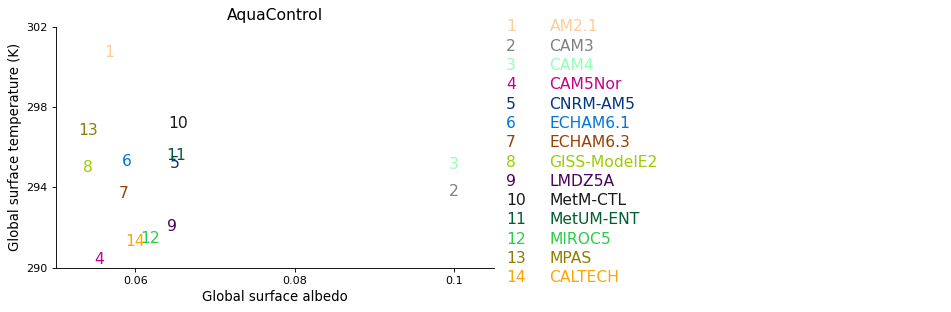

In [10]:
plt.figure( figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k' )  

ax = plt.subplot(1, 2, 1) 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left') 
for model in ts.keys():
    plt.text(alpha[model], ts[model].values, plotdict[model]['nbr'], color=plotdict[model]['color'], fontsize=14, 
    fontweight='normal', ha='center', va='center', backgroundcolor='none')
plt.xlim(0.05, 0.105), plt.ylim(290, 302)
plt.title('AquaControl', fontsize=14)
plt.xlabel('Global surface albedo', fontsize=12)
plt.ylabel('Global surface temperature (K)', fontsize=12)
ax.xaxis.set_ticks([0.06, 0.08, 0.1])
ax.xaxis.set_ticklabels([0.06, 0.08, 0.10], fontsize=10)
ax.yaxis.set_ticks([290, 294, 298, 302])
ax.yaxis.set_ticklabels([290, 294, 298, 302], fontsize=10)

ax = plt.subplot(1, 2, 2)
plt.xlim(0, 1), plt.ylim(0, 1)
plt.axis('off')
for model in ts.keys():
    plt.text(0.0, 1.06-0.08*np.float(plotdict[model]['nbr']), plotdict[model]['nbr'] , color=plotdict[model]['color'], fontsize=14)
    plt.text(0.1, 1.06-0.08*np.float(plotdict[model]['nbr']), plotdict[model]['name'], color=plotdict[model]['color'], fontsize=14)

plt.tight_layout()